In [1]:
print("1")

1


In [2]:
conda install torch, numpy, matplotlib

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... failed

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - torch
  - numpy

Current channels:

  - defaults
  - https://repo.anaconda.com/pkgs/main
  - https://repo.anaconda.com/pkgs/r
  - https://repo.anaconda.com/pkgs/msys2

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Running on device: cpu
--- Starting Training ---
Epoch 10/100 | Train Loss: 0.003747 | Test Loss: 0.004428
Epoch 20/100 | Train Loss: 0.001192 | Test Loss: 0.000678
Epoch 30/100 | Train Loss: 0.000213 | Test Loss: 0.000230
Epoch 40/100 | Train Loss: 0.000228 | Test Loss: 0.000201
Epoch 50/100 | Train Loss: 0.000114 | Test Loss: 0.000161
Epoch 60/100 | Train Loss: 0.000090 | Test Loss: 0.000106
Epoch 70/100 | Train Loss: 0.000074 | Test Loss: 0.000102
Epoch 80/100 | Train Loss: 0.000065 | Test Loss: 0.000087
Epoch 90/100 | Train Loss: 0.000057 | Test Loss: 0.000068
Epoch 100/100 | Train Loss: 0.000062 | Test Loss: 0.000102
--- Training Finished ---
--- Plotting Test Sample ---
Saved plot to fno_derivative_prediction.png


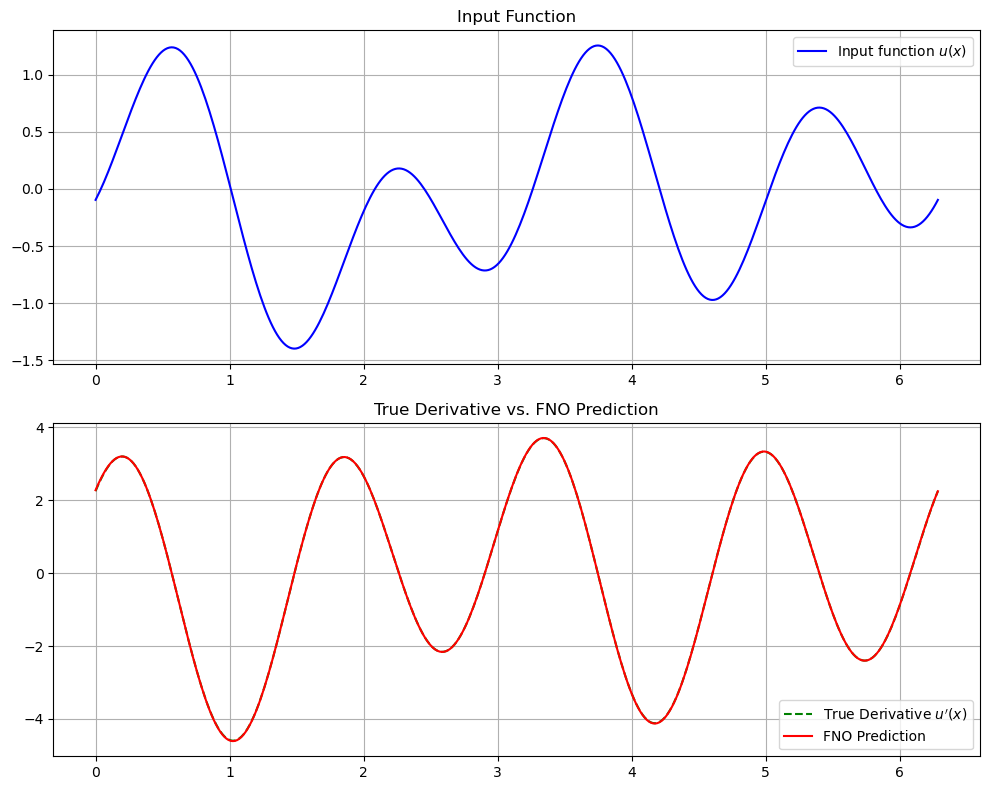

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

################################################################
# 1. Fourier Layer (Spectral Convolution)
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        
        Args:
            in_channels (int): Input channels
            out_channels (int): Output channels
            modes (int): Number of Fourier modes to keep
        """
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  # Number of Fourier modes to keep (top k low-frequency modes)

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes, dtype=torch.cfloat))

    def forward(self, x):
        batchsize = x.shape[0]
        
        # Apply 1D FFT
        # x shape: (batch, in_channels, n_points) -> x_ft shape: (batch, in_channels, n_points // 2 + 1)
        x_ft = torch.fft.rfft(x)

        # Multiply by weights in Fourier domain (only on the low-frequency modes)
        # We create an output tensor with zeros and fill in the learned modes.
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        
        # Einstein summation for efficient batch-wise matrix multiplication
        # b: batch, i: in_channels, o: out_channels, m: modes
        # We multiply the first 'modes' of the input FFT with the weights
        out_ft[:, :, :self.modes] = torch.einsum("bim,iom->bom", x_ft[:, :, :self.modes], self.weights)

        # Apply 1D Inverse FFT
        # out_ft shape: (batch, out_channels, n_points // 2 + 1) -> x shape: (batch, out_channels, n_points)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

################################################################
# 2. FNO Model Architecture
################################################################
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        Fourier Neural Operator for 1D problem.
        
        Args:
            modes (int): Number of Fourier modes
            width (int): Channel width of the network
        """
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width
        
        # Input: u(x) and the grid coordinate x. So 2 input channels.
        # We "lift" the input to the channel dimension 'width'
        self.fc0 = nn.Linear(2, self.width)  

        # 4 Fourier layers
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.w0 = nn.Conv1d(self.width, self.width, 1) # Pointwise linear layer (kernel_size=1)
        
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        # We "project" from the channel dimension back to 1 (the output function)
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch, 1, n_points)
        
        # Get the grid and add it as a channel
        grid = self.get_grid(x.shape, x.device) # (batch, 1, n_points)
        x = torch.cat((x, grid), dim=1) # (batch, 2, n_points)
        
        # Permute for linear layer: (batch, n_points, 2)
        x = x.permute(0, 2, 1)
        
        # Lift to high-dimensional space
        x = self.fc0(x) # (batch, n_points, width)
        
        # Permute for spectral conv: (batch, width, n_points)
        x = x.permute(0, 2, 1)

        # Fourier Layer 1
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2 # Residual connection
        x = F.gelu(x)

        # Fourier Layer 2
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        # Fourier Layer 3
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        # Fourier Layer 4
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # No activation on last layer before projection

        # Permute for projection: (batch, n_points, width)
        x = x.permute(0, 2, 1)

        # Project back to 1D output
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x) # (batch, n_points, 1)
        
        # Permute to match target shape: (batch, 1, n_points)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        """
        Returns a 1D grid tensor.
        """
        batchsize, _, nx = shape
        gridx = torch.linspace(0, 2 * np.pi, nx, device=device)
        gridx = gridx.reshape(1, 1, nx).repeat(batchsize, 1, 1)
        return gridx

################################################################
# 3. Data Generation
################################################################
def get_data(n_samples, n_points):
    """
    Generates training data.
    Input u(x) is a sum of 5 sinusoids.
    Output f(x) is the analytical derivative du/dx.
    """
    x = torch.linspace(0, 2 * np.pi, n_points).view(1, 1, -1)
    u = torch.zeros(n_samples, 1, n_points)
    du_dx = torch.zeros(n_samples, 1, n_points)
    
    for i in range(n_samples):
        u_i = torch.zeros(1, 1, n_points)
        du_i = torch.zeros(1, 1, n_points)
        for _ in range(5): # Sum of 5 sines
            A = np.random.rand() * 2 - 1  # Amplitude [-1, 1]
            k = np.random.randint(1, 6)   # Wavenumber [1, 5]
            phi = np.random.rand() * 2 * np.pi # Phase [0, 2pi]
            
            u_i += A * torch.sin(k * x + phi)
            du_i += A * k * torch.cos(k * x + phi)
            
        u[i] = u_i
        du_dx[i] = du_i
        
    return u, du_dx, x.squeeze()

################################################################
# 4. Training Loop
################################################################
def main():
    # --- Hyperparameters ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {DEVICE}")

    MODES = 16      # Number of Fourier modes
    WIDTH = 64      # Channel width
    BATCH_SIZE = 20
    EPOCHS = 100
    LEARNING_RATE = 0.001
    
    N_SAMPLES_TRAIN = 1000
    N_SAMPLES_TEST = 100
    N_POINTS = 400  # Discretization points

    # --- Data ---
    u_train, du_train, _ = get_data(N_SAMPLES_TRAIN, N_POINTS)
    u_test, du_test, x_grid = get_data(N_SAMPLES_TEST, N_POINTS)
    
    train_dataset = torch.utils.data.TensorDataset(u_train, du_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    test_dataset = torch.utils.data.TensorDataset(u_test, du_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Model ---
    model = FNO1d(MODES, WIDTH).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    criterion = nn.MSELoss()

    print("--- Starting Training ---")
    for ep in range(EPOCHS):
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        scheduler.step()
        train_loss /= len(train_loader)
        
        # Test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                test_loss += criterion(out, y).item()
        test_loss /= len(test_loader)
        
        if (ep + 1) % 10 == 0:
            print(f"Epoch {ep+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

    print("--- Training Finished ---")

    # --- Evaluation & Plotting ---
    print("--- Plotting Test Sample ---")
    model.eval()
    
    # Get one sample from the test set
    u_sample = u_test[0:1].to(DEVICE)   # (1, 1, n_points)
    du_true = du_test[0:1].to(DEVICE) # (1, 1, n_points)
    
    with torch.no_grad():
        du_pred = model(u_sample)

    # Move to CPU for plotting
    x_grid = x_grid.cpu().numpy()
    u_sample = u_sample.squeeze().cpu().numpy()
    du_true = du_true.squeeze().cpu().numpy()
    du_pred = du_pred.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(x_grid, u_sample, label='Input function $u(x)$', color='blue')
    plt.title("Input Function")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(x_grid, du_true, label='True Derivative $u\'(x)$', color='green', linestyle='--')
    plt.plot(x_grid, du_pred, label='FNO Prediction', color='red', linestyle='-')
    plt.title("True Derivative vs. FNO Prediction")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("fno_derivative_prediction.png")
    print("Saved plot to fno_derivative_prediction.png")
    plt.show()

if __name__ == "__main__":
    main()